# CrateDB Cloud Import

This is an example notebook demonstrating how to load data from
files using the [Import API] interface of [CrateDB Cloud] into
a [CrateDB Cloud Cluster].

The supported file types are CSV, JSON, Parquet, optionally with
gzip compression. They can be acquired from the local filesystem,
or from remote HTTP and AWS S3 resources.

[CrateDB Cloud]: https://cratedb.com/docs/cloud/
[CrateDB Cloud Cluster]: https://cratedb.com/docs/cloud/en/latest/reference/services.html
[Import API]: https://community.cratedb.com/t/importing-data-to-cratedb-cloud-clusters/1467

## Setup

To install the client SDK, use `pip`.

In [ ]:
#!pip install 'cratedb-toolkit'

## Configuration

The notebook assumes you are appropriately authenticated to the CrateDB Cloud
platform, for example using `croud login --idp azuread`. To inspect the list
of available clusters, run `croud clusters list`.

For addressing a database cluster, and obtaining corresponding credentials,
the program uses environment variables, which you can define interactively,
or store them within a `.env` file.

You can use those configuration snippet as a blueprint. Please adjust the
individual settings accordingly.
```shell
CRATEDB_CLOUD_CLUSTER_NAME=Hotzenplotz
CRATEDB_USERNAME='admin'
CRATEDB_PASSWORD='H3IgNXNvQBJM3CiElOiVHuSp6CjXMCiQYhB4I9dLccVHGvvvitPSYr1vTpt4'
```

## Acquire Database Cluster

As a first measure, acquire a resource handle, which manages a CrateDB Cloud
cluster instance.

For effortless configuration, it will obtain configuration settings from
environment variables as defined above.

In [6]:
import cratedb_toolkit as ctk

# FIXME: HEADLESS!
cluster = ctk.ManagedCluster.from_env().start()

## Import Data

The venerable New York City [TLC Trip Record Data] dataset includes taxi trip
data capturing pick-up and drop-off dates/times, pick-up and drop-off locations,
trip distances, itemized fares, rate types, payment types, and driver-reported
passenger counts.

The next code cell will import 15 million records worth of data from a Parquet
file using the [CrateDB Cloud Import] API.

[CrateDB Cloud Import]: https://community.cratedb.com/t/importing-data-to-cratedb-cloud-clusters/1467
[TLC Trip Record Data]: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [21]:
# Define data source.
url = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2010-04.parquet"
source = ctk.InputOutputResource(url=url)
target = ctk.TableAddress(schema="testdrive")

# Invoke import job. Without `target` argument, the destination
# table name will be derived from the input file name.
cluster.load_table(source=source, target=target)

==> Info: Status: REGISTERED (Your import job was received and is pending processing.)
==> Info: Status: SENT (Your creation request was sent to the region.)
==> Info: Status: IN_PROGRESS (Import in progress)
==> Info: importing... 270.00K records (1.78%) imported so far.
==> Info: importing... 660.00K records (4.36%) imported so far.
==> Info: importing... 880.00K records (5.81%) imported so far.
==> Info: importing... 1.25M records (8.25%) imported so far.
==> Info: importing... 1.61M records (10.63%) imported so far.
==> Info: importing... 1.98M records (13.07%) imported so far.
==> Info: importing... 2.34M records (15.45%) imported so far.
==> Info: importing... 2.71M records (17.89%) imported so far.
==> Info: importing... 3.07M records (20.27%) imported so far.
==> Info: importing... 3.45M records (22.78%) imported so far.
==> Info: importing... 3.94M records (26.02%) imported so far.
==> Info: importing... 4.31M records (28.46%) imported so far.
==> Info: importing... 4.66M reco

CloudJob(info={'cluster_id': '11cbcb3d-7057-4f80-adc3-38673838b38e', 'compression': 'none', 'dc': {'created': '2023-11-18T03:04:18.497000+00:00', 'modified': '2023-11-18T03:04:18.497000+00:00'}, 'destination': {'create_table': True, 'table': '"testdrive"."yellow_tripdata_2010-04"'}, 'file': None, 'format': 'parquet', 'id': 'b4d4711b-7912-4590-a4a6-bfca1dee2d4b', 'progress': {'bytes': 0, 'details': {'create_table_sql': 'CREATE TABLE "testdrive"."yellow_tripdata_2010-04" ("vendor_id" VARCHAR,"pickup_datetime" VARCHAR,"dropoff_datetime" VARCHAR,"passenger_count" BIGINT,"trip_distance" DOUBLE,"pickup_longitude" DOUBLE,"pickup_latitude" DOUBLE,"rate_code" VARCHAR,"store_and_fwd_flag" VARCHAR,"dropoff_longitude" DOUBLE,"dropoff_latitude" DOUBLE,"payment_type" VARCHAR,"fare_amount" DOUBLE,"surcharge" DOUBLE,"mta_tax" DOUBLE,"tip_amount" DOUBLE,"tolls_amount" DOUBLE,"total_amount" DOUBLE)'}, 'failed_files': 0, 'failed_records': 0, 'message': 'Import succeeded', 'percent': 100.0, 'processed_fil

## Load Data

In [13]:
import dask.dataframe as dd
import pandas as pd

# Acquire database clients.
client_bundle = cluster.get_client_bundle()

# Quickly inspect the number of records.
# TODO: Provide `count_records` functions directly on `cluster` object?
total_count = client_bundle.adapter.count_records('"testdrive"."yellow_tripdata_2010-04"')
print(f"Number of records: {total_count}")

# Query data from database.
sql = 'SELECT dropoff_longitude, dropoff_latitude, pickup_longitude, pickup_latitude, passenger_count ' \
      'FROM "testdrive"."yellow_tripdata_2010-04" LIMIT 5000;'
df = pd.read_sql(sql=sql, con=client_bundle.sqlalchemy)

# TODO: Use Dask for reading from database?
# df = dd.read_sql(sql=sql, con=client_bundle.adapter.dburi)

# Inspect DataFrame.
df

Number of records: 15144990


,dropoff_longitude,dropoff_latitude,pickup_longitude,pickup_latitude,passenger_count
0,-73.995568,40.733463,-73.990177,40.756135,1
1,-73.975875,40.734825,-73.988605,40.736607,1
2,-73.945578,40.815380,-73.981063,40.733482,2
3,-73.965268,40.684530,-74.007440,40.713240,1
4,-74.006438,40.739648,-73.980638,40.761542,3
...,...,...,...,...,...
4995,-73.972765,40.757685,-73.999252,40.723053,3
4996,-73.931530,40.757507,-73.936367,40.758273,1
4997,-73.952612,40.765850,-73.947745,40.783605,2
4998,-73.989458,40.752847,-73.972528,40.747457,1


## Data Refinement

Before visualizing the DataFrame loaded from the database, it will be filtered
by a bounding box limiter, and transformed into a categorical DataFrame, while
unifying names of previously different geolocation column names into canonical
`longitude` / `latitude` columns.

In [8]:
# Limit data to bounding box around NYC.
# TODO: Reformulate into WHERE clause of SQL expression.
df = df.loc[
    (df.dropoff_longitude > -74.1) & (df.dropoff_longitude < -73.7) &
    (df.dropoff_latitude > 40.6) & (df.dropoff_latitude < 40.9) &
    (df.pickup_longitude > -74.1) & (df.pickup_longitude < -73.7) &
    (df.pickup_latitude > 40.6) & (df.pickup_latitude < 40.9)
]

# Create a DataFrame with `{dropoff,pickup}_{longitude,latitude}` converged
# into `longitude`/`latitude` and a `journey_type` categorical column.
# TODO: Can this be reformulated into SQL as well?

# Get a DataFrame with just drop-off locations.
df_drop = df[["dropoff_longitude", "dropoff_latitude", "passenger_count"]]
df_drop.loc[:, ("journey_type",)] = "dropoff"
df_drop = df_drop.rename(columns={"dropoff_longitude": "longitude", "dropoff_latitude": "latitude"})

# Get a DataFrame with just pickup locations.
df_pick = df[["pickup_longitude", "pickup_latitude", "passenger_count"]]
df_pick.loc[:, ("journey_type",)] = "pickup"
df_pick = df_pick.rename(columns={"pickup_longitude": "longitude", "pickup_latitude": "latitude"})

# Create unified categorized DataFrame suitable for plotting.
df_plot = dd.concat([df_drop, df_pick])
df_plot = df_plot.astype({"journey_type": "category"})
df_plot["journey_type"] = df_plot["journey_type"].cat.set_categories(["dropoff", "pickup"])

# Partitions are small, it is better to repartition.
df_plot = df_plot.persist()
df_plot = df_plot.repartition(partition_size="256MiB").persist()

print("Number of records:", len(df_plot))

Number of records: 973068


## Visualize

In order to visualize the DataFrame prepared above, let's use the excellent [hvPlot]
and [Datashader] packages, based on [HoloViews], from the family of [HoloViz] packages
of [PyViz] fame.

With Datashader, we can choose what we want to plot on the x and y axes and see the full data immediately, with no parameter tweaking, magic numbers, subsampling, or approximation, up to the resolution of the display

[Datashader]: https://datashader.org/
[HoloViews]: https://www.holoviews.org/
[HoloViz]: https://holoviz.org/
[hvPlot]: https://hvplot.holoviz.org/
[PyViz]: https://pyviz.org/

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
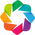

In [9]:
import colorcet as cc
import datashader as ds
import holoviews as hv
import holoviews.operation.datashader as hd
import hvplot.dask

hv.extension("bokeh")

plot_width  = int(750)
plot_height = int(plot_width//1.33)

plot_options = hv.Options(
    width=plot_width,
    height=plot_height,
    xaxis=None,
    yaxis=None,
    bgcolor="black",
    border=0,
    legend_position="bottom_right",
)

### Scatterplot

First, let's do a quick scatter plot displaying both pickup and dropoff locations.

In [25]:
color_key = {"pickup": "#EF1561", "dropoff": "#1F5AFF"}
df_plot.hvplot.scatter(
    x="longitude",
    y="latitude",
    aggregator=ds.by("journey_type"),
    datashade=True,
    cnorm="eq_hist",
    color_key=color_key,
).opts(plot_options).opts(bgcolor="white")

:DynamicMap   []
   :RGB   [longitude,latitude]   (R,G,B,A)

### Colormapping

Datashader's `datashade()` convenience function applies the aggregate and shade
operations, aggregating all elements in the supplied object and then applying
normalization and color-mapping the aggregated data, returning RGB elements.

This example uses the passenger count value for the aggregation part of the
datashade operation.

 With Datashader, we can choose what we want to plot on the x and y axes and see the full data immediately, with no parameter tweaking, magic numbers, subsampling, or approximation, up to the resolution of the display:

In [26]:
points = hv.Points(df_plot, ["longitude", "latitude"])
shaded = hd.datashade(points, cmap=ds.colors.viridis, aggregator=ds.count("passenger_count"))
plot   = hd.dynspread(shaded, threshold=0.5, max_px=4)

plot.opts(plot_options)

:DynamicMap   []
   :RGB   [longitude,latitude]   (R,G,B,A)

## Visualize on a Map

Overlay the data on digital geographic maps, by using open map tiles, for
example from OSM or ESRI.

Note that HoloViews/Bokeh works with Web Mercator coordinates, so you will
need to convert geolocation positions from original longitude / latitude
values.

In [0]:
df_map_plot = df_plot.copy()
df_map_plot.longitude, df_map_plot.latitude = hv.Tiles.lon_lat_to_easting_northing(df_map_plot.longitude, df_map_plot.latitude)

### Overlay on a streets map

This examples uses map tiles from Open Street Maps (OSM).

In [62]:
# Create a map tiles layer, and a points layer.
# HoloViews defines overlays using the star operator.
map_tiles  = hv.element.OSM()
points     = hv.Points(df_map_plot, ["longitude", "latitude"])
shaded     = hd.datashade(points, x_sampling=1, y_sampling=1)
plot       = map_tiles * shaded

plot.opts(plot_options)

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [longitude,latitude]   (R,G,B,A)

### Overlay on a map with satellite imagery

This example uses map tiles from the [Esri World Imagery Map], colormapping to
a contrast-rich color palette.

[Esri World Imagery Map]: https://www.arcgis.com/home/item.html?id=50c23e4987a44de4ab163e1baeab4a46

In [49]:
map_tiles  = hv.element.EsriImagery().opts(alpha=0.5)
points     = hv.Points(df_map_plot, ["longitude", "latitude"])
#shaded     = hd.datashade(points, x_sampling=1, y_sampling=1, cmap=cc.kbc)
#shaded     = hd.datashade(points, x_sampling=1, y_sampling=1, cmap=cc.CET_L20)
shaded     = hd.datashade(points, x_sampling=1, y_sampling=1, cmap=cc.CET_R4)
#shaded     = hd.datashade(points, cmap=cc.CET_R4)
plot       = map_tiles * shaded

plot.opts(plot_options)

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [longitude,latitude]   (R,G,B,A)